### Getting Started with LangGraph API

In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages:Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [3]:
graph_builder 

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="llama-3.3-70b-versatile")
# Or USE
# llm = init_chat_model("groq:llama-3.3-70b-versatile")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x71577cfc0050>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x71577cfc0d70>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [11]:
# Node Functionality

def chatbot(state:State):
    return{"messages": [llm.invoke(state["messages"])]}

In [12]:

graph_builder = StateGraph(State)

# Adding Nod
graph_builder.add_node("llmchatbot", chatbot)
# Adding Edge
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

# Compile the graph
graph = graph_builder.compile()

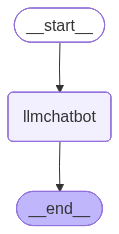

In [ ]:
## Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
response = graph.invoke({"messages":"Hi"})

KeyError: 'messages'

In [ ]:
response["messages"][-1].content

NameError: name 'response' is not defined

In [16]:
for event in graph.stream({"messages": "Hi! How are you doing today?"}):
    for value in event.values():
        print(value["messages"][-1].content)

KeyError: 'messages'